In [1]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

# basic imports
from platform import python_version
import tensorflow as tf 
import tensorflow_io as tfio
import os
import numpy as np
import datetime
import tensorflow_hub as hub

from keras.utils import dataset_utils
import matplotlib.pyplot as plt

from IPython import display
import librosa
import glob
import imageio
import PIL
import tensorflow as tf
import time

import skimage

import baseline_config

# print system information
print('Python Version        : ', python_version())
print('TensorFlow Version    : ', tf.__version__)
print('TensorFlow IO Version : ', tfio.__version__)
print('Librosa Version       : ', librosa.__version__)

Python Version        :  3.8.16
TensorFlow Version    :  2.10.1
TensorFlow IO Version :  0.27.0
Librosa Version       :  0.10.0


In [2]:
def enforce_memory_limit(mem_mb):
  # enforce memory limit on GPU

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_mb)])
      print(f"vram limit set to {mem_mb}MB")
    except RuntimeError as e:
      print(e)
      
# enforce max 5 GB memory on GPU for this notebook
# enforce_memory_limit(5120)

In [3]:
########################################################################################
# MODEL PARAMETERS
########################################################################################
MODEL_INPUT_IMAGE_WIDTH = 256
MODEL_INPUT_IMAGE_HEIGHT = 256
MODEL_INPUT_IMAGE_CHANNELS = 3

In [4]:
def paths_and_labels_to_dataset(image_paths,labels,num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    img_ds = path_ds.map(
        lambda path: tf.io.read_file(path), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    img_ds = tf.data.Dataset.zip((img_ds, label_ds))
    return img_ds

def create_dataset(subset):
    image_paths, labels, class_names = dataset_utils.index_directory(
            baseline_config.dataset_path + subset,
            labels="inferred",
            formats=('.pt'),
            class_names=None,
            shuffle=True,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=image_paths,
        labels=labels,
        num_classes=len(class_names))
    
    return dataset, class_names

train_dataset, class_names = create_dataset('TRAIN/')
test_dataset, _            = create_dataset('TEST/')
validation_dataset, _      = create_dataset('VALIDATION/')
print("class names: ", class_names)

Found 19809 files belonging to 20 classes.
Found 99 files belonging to 20 classes.
Found 1409 files belonging to 20 classes.
class names:  ['Aegotheles cristatus owlet-nightjar', 'Alauda arvensis European Skylark', 'Caligavis chrysops Yellow-faced honeyeater', 'Capra hircus Feral goat', 'Cervus unicolour Sambar deer', 'Colluricincla harmonica Grey shrikethrush', 'Corvus coronoides Australian raven', 'Dama dama Fallow Deer', 'Eopsaltria australis Eastern yellow robin', 'Felis Catus Cat', 'Pachycephala rufiventris Rufous whistler', 'Ptilotula penicillata White-plumed honeyeater', 'Rattus norvegicus Brown rat', 'Strepera graculina Pied currawong', 'brant', 'jabwar', 'sheowl', 'spodov', 'sus scrofa Wild pig', 'wiltur']


In [5]:

def dataset_transforms(image, label):
    # reshape into standard 3 channels
    image = tf.io.parse_tensor(image, tf.float32)
    image = tf.expand_dims(image, -1)
    
    # most pre-trained model expect 3 color channels
    image = tf.repeat(image, MODEL_INPUT_IMAGE_CHANNELS, axis=2)
    
    image = tf.ensure_shape(image, [216, 128, MODEL_INPUT_IMAGE_CHANNELS])
    image = tf.image.resize(image, (MODEL_INPUT_IMAGE_WIDTH,MODEL_INPUT_IMAGE_HEIGHT), 
                            method=tf.image.ResizeMethod.BICUBIC)
    
    # for some reason the melspecs seem rotated by 90 degrees. This corrects that.
    image = tf.image.rot90(image, k=1)
    
    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / (tf.reduce_max(image)+0.00000001)
    
    return image,label

train_dataset_b = ( 
                  train_dataset       
                  .shuffle(2000)
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)        
                )

validation_dataset_b = ( 
                  validation_dataset
                  .shuffle(2000)
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)
                )

test_dataset_b = ( 
                  test_dataset
                  .shuffle(2000)
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)
                )

 item and label shapes (32, 256, 256, 3) , (32, 20)
 min and max pixel value 0.0, 1.0


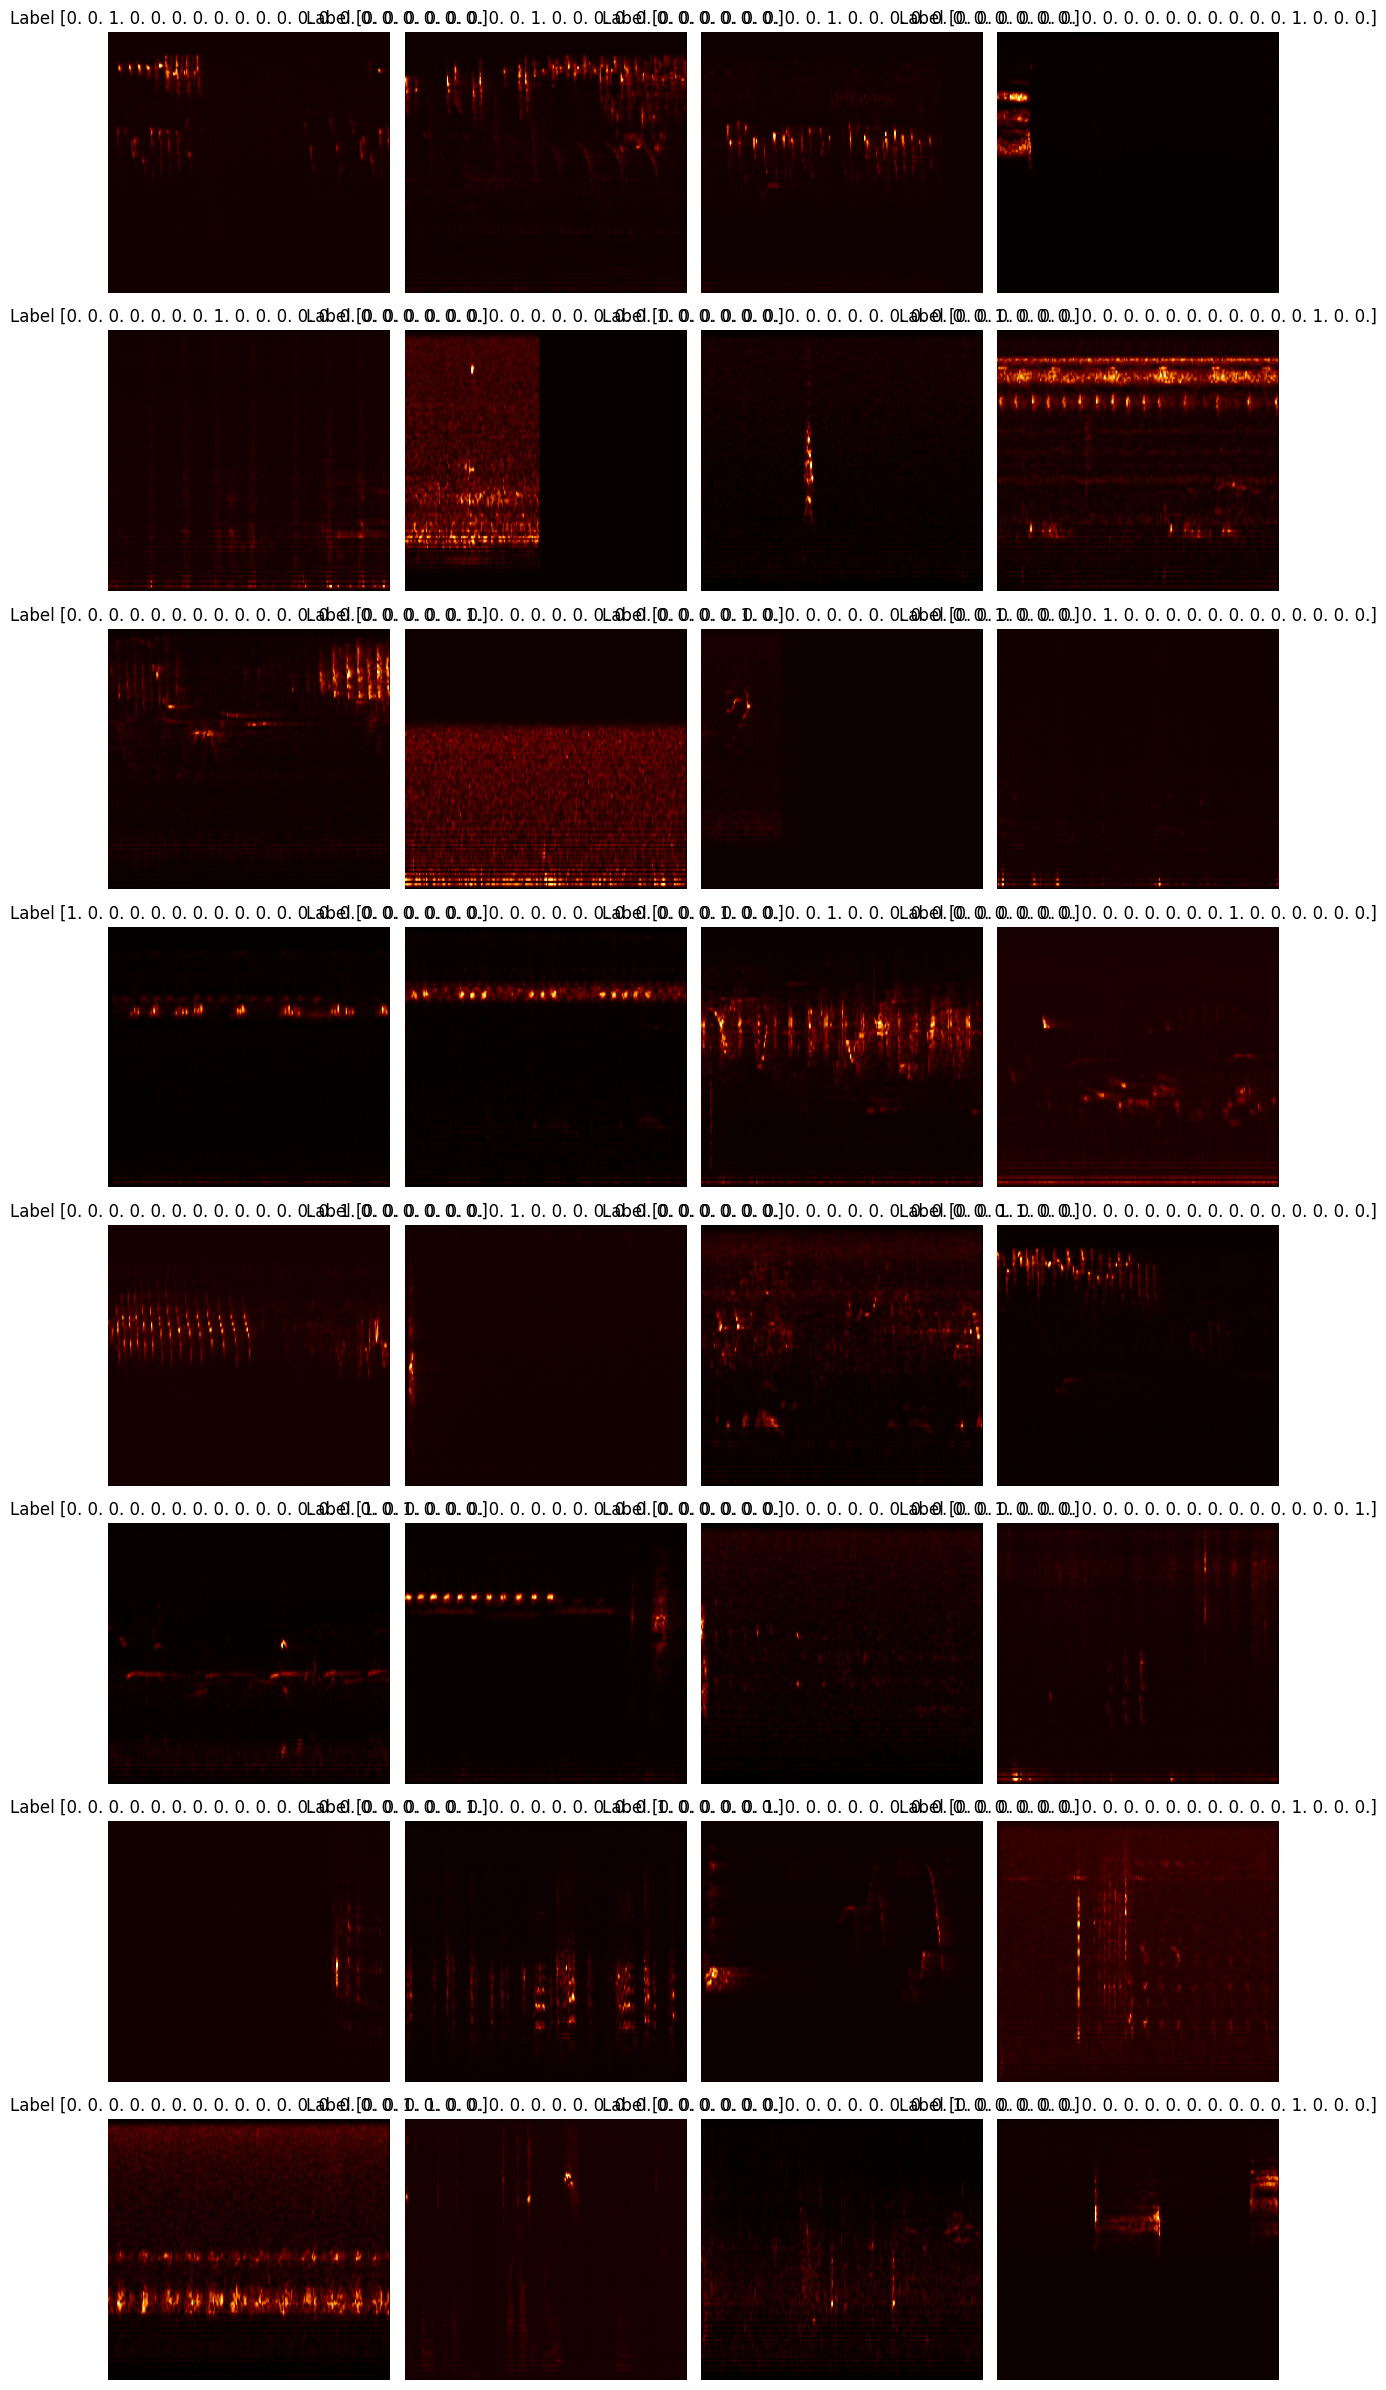

In [6]:
# take 1 batch worth of data from the dataset
for item,lbl in train_dataset_b.take(1):
    print(f' item and label shapes {item.shape} , {lbl.shape}')
    print(f' min and max pixel value {np.min(item)}, {np.max(item)}')
    
    grid_size = (8, 4)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 24))
    
    # lets look at what the batch contains
    b = 0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            melspec = item[b,:,:,0]
            ax = axes[i, j]
            plot_index = i * grid_size[1] + j
            ax.imshow(melspec, cmap='afmhot', aspect='auto')
            ax.set_title(f' examples ')
            ax.axis('off')
            b = b + 1
            
    plt.tight_layout()
    plt.show()

In [7]:
# based on https://www.tensorflow.org/tutorials/generative/cvae

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    
    super(CVAE, self).__init__()
    
    self.latent_dim = latent_dim
    
    ks=3
    stride =2
    
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_WIDTH, MODEL_INPUT_IMAGE_CHANNELS)),
      
      tf.keras.layers.Conv2D(256, (ks,ks), 
                             activation=tf.nn.leaky_relu, 
                             padding='same', 
                             strides=stride),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2D(128, (ks,ks), 
                             activation=tf.nn.leaky_relu, 
                             padding='same', 
                             strides=stride),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2D(64, (ks,ks), 
                             activation=tf.nn.leaky_relu, 
                             padding='same', 
                             strides=stride),
      tf.keras.layers.BatchNormalization(),      
      
      tf.keras.layers.Conv2D(32, (ks,ks), 
                             activation=tf.nn.leaky_relu, 
                             padding='same', 
                             strides=stride),
      tf.keras.layers.BatchNormalization(),
    ])

    self.decoder = tf.keras.Sequential([
        
      tf.keras.layers.Conv2DTranspose(32, kernel_size=ks, 
                                      strides=stride, 
                                      activation=tf.nn.leaky_relu, 
                                      padding='same'),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2DTranspose(64, kernel_size=ks, 
                                      strides=stride, 
                                      activation=tf.nn.leaky_relu, 
                                      padding='same'),
      tf.keras.layers.BatchNormalization(),      
      
      tf.keras.layers.Conv2DTranspose(128, kernel_size=ks, 
                                      strides=stride, 
                                      activation=tf.nn.leaky_relu, 
                                      padding='same'),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2DTranspose(256, kernel_size=ks, 
                                      strides=stride, 
                                      activation=tf.nn.leaky_relu, 
                                      padding='same'),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2D(MODEL_INPUT_IMAGE_CHANNELS, 
                             kernel_size=(ks, ks), 
                             activation='sigmoid', 
                             padding='same')
    ])
    
    # adding class information to make this semi-supervised
    self.classifier = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(16,16,32)),
            # tf.keras.layers.Input(shape=(MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_WIDTH, MODEL_INPUT_IMAGE_CHANNELS)),
            
            tf.keras.layers.Conv2D(3, (1,1), 
                             activation=tf.nn.leaky_relu, 
                             padding='same', 
                             strides=1),
            tf.keras.layers.BatchNormalization(),
      
            hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2", True), 
            
            #tf.keras.layers.Conv2D(128, kernel_size=ks, strides=stride, activation=tf.nn.leaky_relu, padding='same'),
            #tf.keras.layers.BatchNormalization(),
      
            #tf.keras.layers.Conv2D(64, kernel_size=ks, strides=stride, activation=tf.nn.leaky_relu, padding='same'),
            #tf.keras.layers.BatchNormalization(),
      
            # flatten to a vector latent space
            tf.keras.layers.Flatten(),
            
            # hidden layers
            tf.keras.layers.Dense(units=len(class_names)*2, activation=tf.nn.relu),
            
            # dropout layer
            # tf.keras.layers.Dropout(0.5),
            
            # output layer
            tf.keras.layers.Dense(
              units=len(class_names), 
              activation=None),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(200, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    return self.encoder(x)
    #mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    #return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [8]:
latent_dim = 32*32*256
epochs = 50

optimizer = tf.keras.optimizers.RMSprop(3e-5)

In [9]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x, y):
  
    encoded = model.encode(x)
     
    # mean, logvar
    
    #z_recon = model.reparameterize(mean, logvar)
    #z_class = model.reparameterize(mean, logvar)
    
    x_recon = model.decode(encoded)
    # print(encoded.shape)
    x_class = model.classifier(encoded)
    
    recon_sum  = tf.math.reduce_sum(x_recon)
    
    recon_loss = tf.keras.metrics.mean_squared_error(x,x_recon) # tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_recon)
    class_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=x_class)
    
    #logpx_z = -tf.reduce_sum(recon_loss, axis=[1, 2, 3])
    #logpz = log_normal_pdf(z_recon, 0., 1.)
    #logqz_x = log_normal_pdf(z_recon, mean, logvar)
    
    #vae_loss = -0.02 * tf.reduce_mean(logpx_z + logpz - logqz_x)
    
    recon_loss = tf.reduce_mean(recon_loss)
    class_loss = tf.reduce_mean(class_loss)
    
    return 1e1*recon_loss + 1*class_loss # + 1e-7*recon_sum

@tf.function
def train_step(model, x, y, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [10]:
feature_model = CVAE(latent_dim)

In [11]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x,target_y in train_dataset_b.take(100):
      train_step(feature_model, train_x, target_y, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x,target_y in validation_dataset_b.take(20):
    loss(compute_loss(feature_model, val_x, target_y))
  val_loss = loss.result()
  print('Epoch: {}, Validation loss: {}, time elapse for current epoch: {}'
        .format(epoch, val_loss, end_time - start_time))

In [ ]:
def softmax(arr):
    # Calculate the exponent of each element in the array
    exp_arr = np.exp(arr)
    
    # Sum the exponentials across the entire array
    exp_sum = np.sum(exp_arr)
    
    # Divide each element's exponential by the sum of exponentials across the entire array
    softmax_arr = exp_arr / exp_sum
    
    return softmax_arr

 out shape (32, 256, 256, 3)


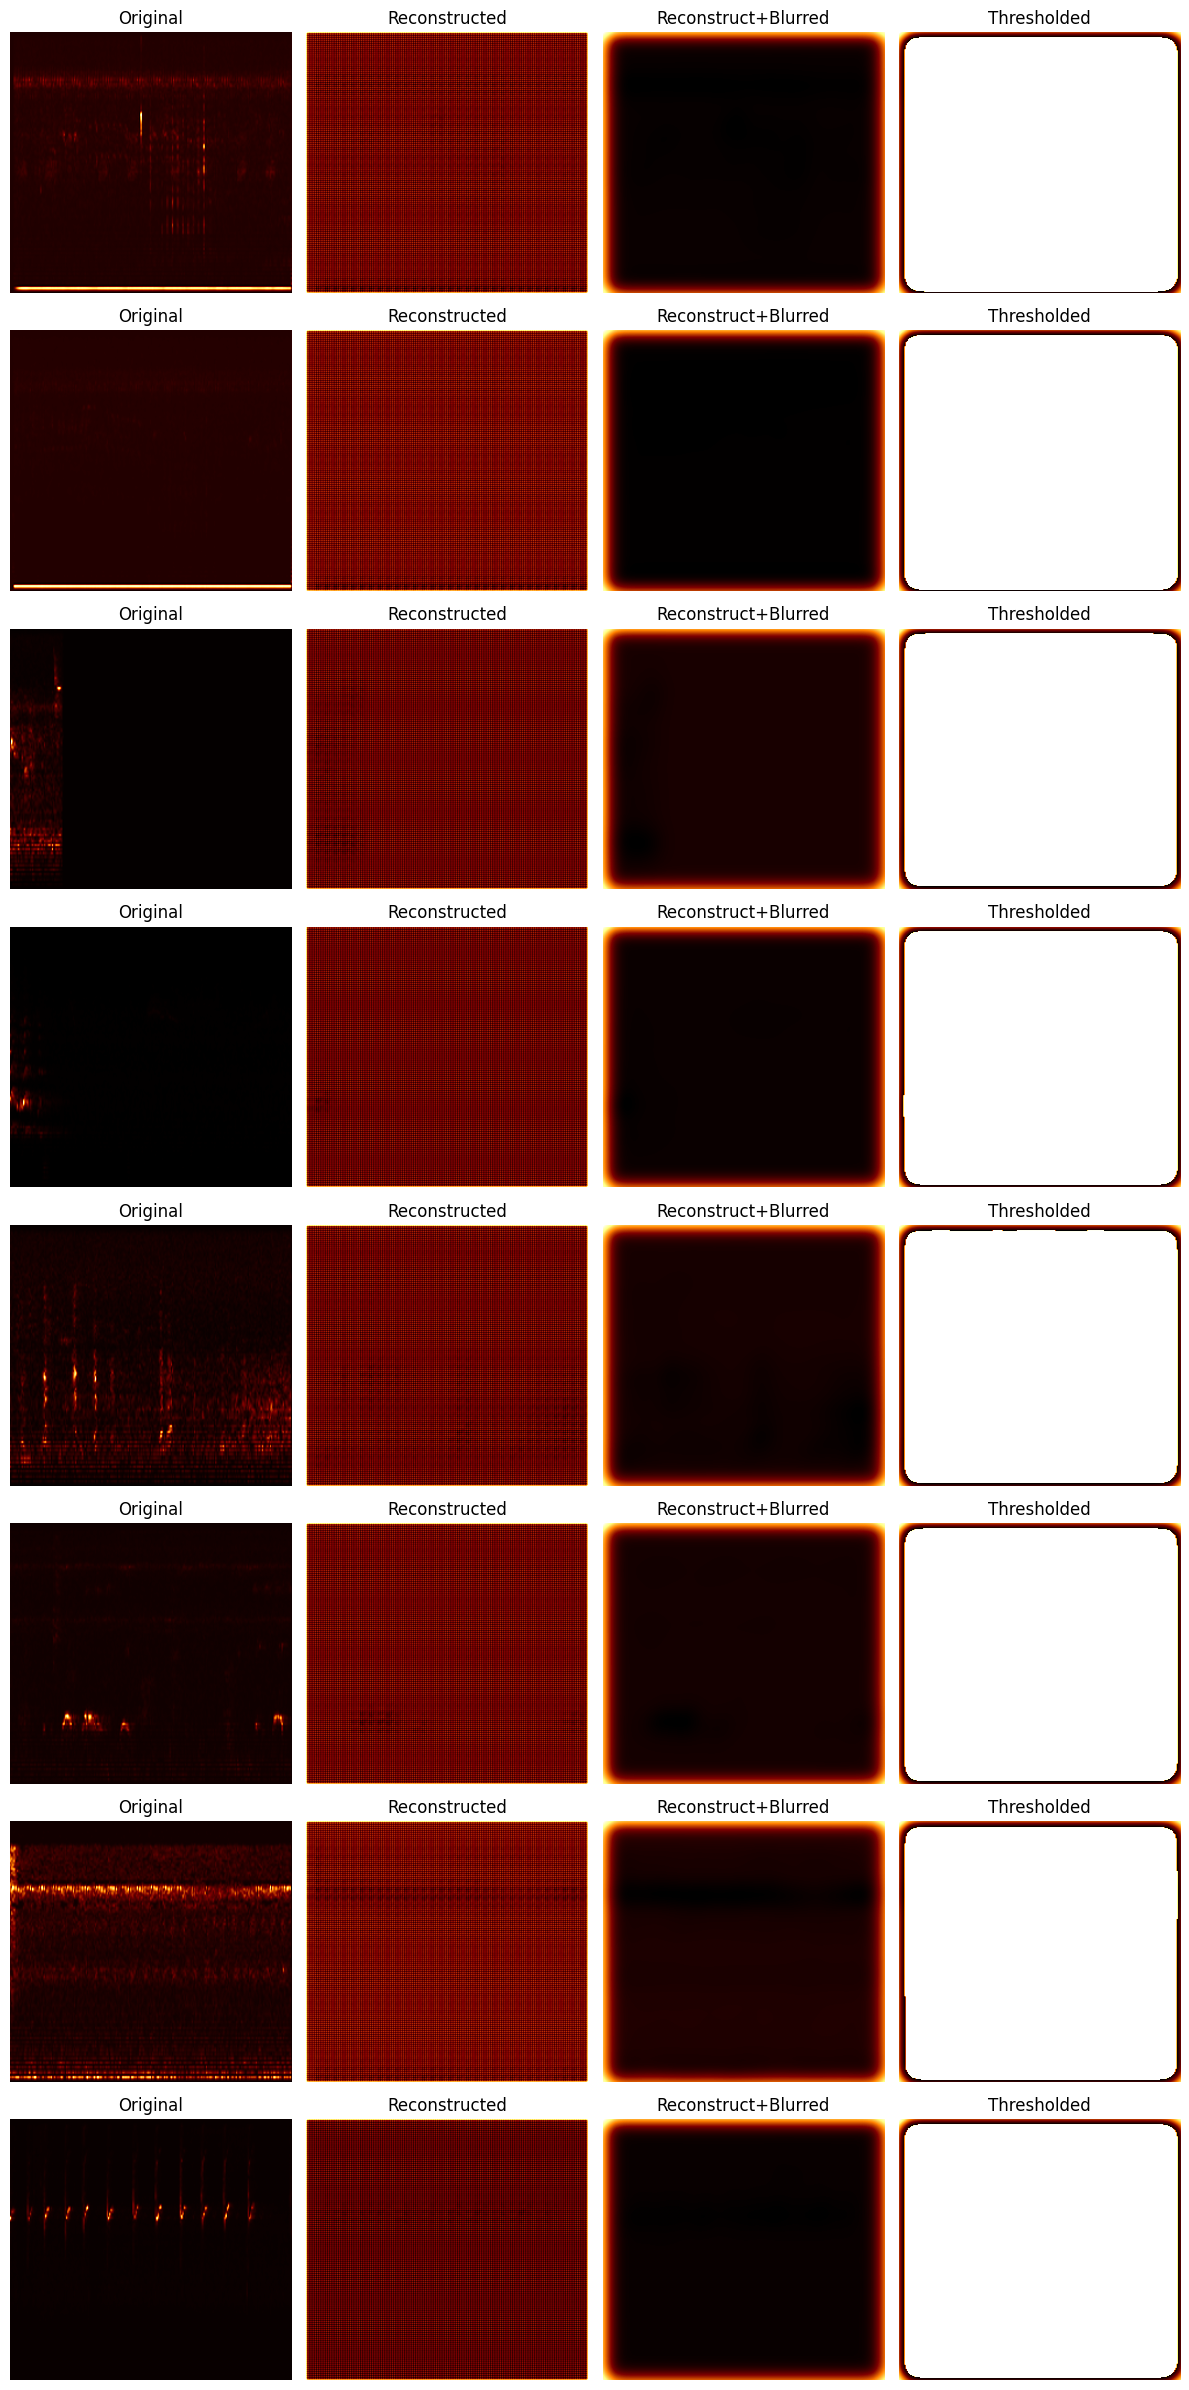

In [ ]:
# take 1 batch worth of data from the dataset
for item,lbl in validation_dataset_b.take(1):
    #print(f' item and label shapes {item.shape} , {lbl.shape}')
    #print(f' min and max pixel value {np.min(item)}, {np.max(item)}')
    
    out = item
    for i in range(1):
        encoded = feature_model.encode(out)
        #z_recon = feature_model.reparameterize(encoded)
        out = feature_model.decode(encoded)
    
    print(f' out shape {out.shape}')
    
    grid_size = (8,4) # 8 rows, 3 cols
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 24))
    
    # lets look at what the batch contains
    b = 0
    for i in range(grid_size[0]):
        j=0
        melspec = item[b,:,:,0]
        ax = axes[i, j]
        plot_index = i * grid_size[1] + j
        ax.imshow(melspec, cmap='afmhot', aspect='auto')
        ax.set_title(f'Original')
        ax.axis('off')
        
        j=1
        melspec = out[b,:,:,0]
        
        ax = axes[i, j]
        plot_index = i * grid_size[1] + j
        ax.imshow(melspec, cmap='afmhot', aspect='auto')
        ax.set_title(f'Reconstructed')
        ax.axis('off')
        
        j=2
        melspec = out[b,:,:,0]
        
        sigma=8
        blurred = skimage.filters.gaussian(
            melspec, sigma=(sigma, sigma), channel_axis=2)
        
        ax = axes[i, j]
        plot_index = i * grid_size[1] + j
        ax.imshow(blurred, cmap='afmhot', aspect='auto')
        ax.set_title(f'Reconstruct+Blurred')
        ax.axis('off')
        
        j=3
        melspec = blurred # softmax(out[b,:,:,0])
        melspec = melspec - np.min(melspec)
        melspec = melspec / (np.max(melspec))
        melspec[melspec < 0.35] = 1
        # melspec = softmax(out[b,:,:,0])
        #print(out[b,:,:,0])
        #print(softmax(out[b,:,:,0]))
        ax = axes[i, j]
        plot_index = i * grid_size[1] + j
        ax.imshow(melspec, cmap='afmhot', aspect='auto')
        ax.set_title(f'Thresholded')
        ax.axis('off')        
               
        b = b + 1
            
    plt.tight_layout()
    plt.show()

In [ ]:
feature_model.encoder.trainable = False

In [ ]:
def build_model(trainable):
    # build a really simple classification model using a pre-training Efficientnet V2
    model = tf.keras.Sequential(
        [
            # input layer
            tf.keras.layers.InputLayer(input_shape=(MODEL_INPUT_IMAGE_WIDTH,MODEL_INPUT_IMAGE_HEIGHT,3)),
  
            # use the model as a feature generator only
            # use pre-trained mobilenet v2 as the feature layer (less parameters, more accessible)
            # hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", trainable),  
            
            hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2", trainable), 
            
            # feature_model.encoder,
            
            # much larger model to see if more parameters matters...
            #hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5", trainable),  
                        
            # add the classification layer here       
            tf.keras.layers.Flatten(), 
            tf.keras.layers.BatchNormalization(),
            
            #tf.keras.layers.Dense(len(class_names)*30, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(1e-2)),
            #tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dense(len(class_names)*2, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(1e-2)),
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(class_names)*1, activation=None),
        ]
    )
    # need to tell the model what the input shape is
    model.build([None, 
                 MODEL_INPUT_IMAGE_HEIGHT,
                 MODEL_INPUT_IMAGE_WIDTH, 
                 MODEL_INPUT_IMAGE_CHANNELS])

    # show the model
    model.summary()
    
    return model

In [ ]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
# allow all the weights to be trained
model = build_model(True)

# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.5,
                                                      patience=4, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-8)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_cnn_model.hdf5', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# fit the model to the training set
model.fit(train_dataset_b, 
          validation_data=validation_dataset_b,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=1000)

111/620 [====>.........................] - ETA: 1:22 - loss: 10.2466 - accuracy: 0.4341

KeyboardInterrupt: 

In [ ]:
# save the model weights
model.save_weights('models/baseline_cnn_model.hdf5', save_format='h5')

# test load the model for inference
test_model = build_model(False)
test_model.build([None, 
                MODEL_INPUT_IMAGE_HEIGHT,
                MODEL_INPUT_IMAGE_WIDTH, 
                MODEL_INPUT_IMAGE_CHANNELS])
test_model.load_weights('models/baseline_cnn_model.hdf5')